# Introuducción

Este dataset fue creado y donado por ZeMA GmbH, un centro de investigación y desarrollo en mecatrónica y tecnologías de automatización ubicado en Alemania.

El dataset fue recopilado realizando ciclos de trabajo (se explicaran con detalle) sucesivos de 60 segundos de duración sobre un banco de pruebas de un circuito, midiendo las variables típicas de un procesos de este tipo (presiones, temperaturas, flujos) a la vez que se "variaba" la condición de sus componentes críticos. El objetivo es poder predecir, en base a las series de tiempo de las señales básicas, el estado de vida útil de los componentes críticos.

El banco consiste en un circuito primario de trabajo (donde circula el fluido por la máquina objetivo a lubricar o refrigerar), y un circuito secundario de enfriamiento para mantener el fluido en cierta temperatura. Los circuitos estan relacionados por un tanque común.
En la siguiente figura se puede observar el esquema de componentes.

<br />

<div style="clear: both">
<img src="img/System.png" style="width: 1000px;float:left">
</div>

<div style="clear: both">
</div>

<br />

In [1]:
import pickle as pkl
import pandas as pd
import numpy as np
from scipy import stats


%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (20, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 20

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
import statistics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

In [2]:
path = './dataset/'

with open(path+ 'df_data_structured.pkl','rb') as file:
    df_x=pkl.load(file)

with open(path + 'df_output_structured.pkl','rb') as file:
    df_y=pkl.load(file)

# Analisis básico de datos


## Señales de entrada

* Tamaño del dataset.
* Nombres de las señales.
* Tipos de datos
* Graficas
* Estadísticos básicos

### Tamaño del dataset

In [3]:
[df_x.shape, len(df_x.dtype.names)]

[(2205, 6000), 17]

El dataset posee la medición de 2205 ciclos de 17 señales con 6000 puntos cada ciclo. 

### Nombres de señales y tipos de datos

In [4]:
df_x.dtype.fields

mappingproxy({'PS1': (dtype('float64'), 0),
              'PS2': (dtype('float64'), 8),
              'PS3': (dtype('float64'), 16),
              'PS4': (dtype('float64'), 24),
              'PS5': (dtype('float64'), 32),
              'PS6': (dtype('float64'), 40),
              'EPS1': (dtype('float64'), 48),
              'FS1': (dtype('float64'), 56),
              'FS2': (dtype('float64'), 64),
              'TS1': (dtype('float64'), 72),
              'TS2': (dtype('float64'), 80),
              'TS3': (dtype('float64'), 88),
              'TS4': (dtype('float64'), 96),
              'VS1': (dtype('float64'), 104),
              'SE': (dtype('float64'), 112),
              'CE': (dtype('float64'), 120),
              'CP': (dtype('float64'), 128)})

Las señales de proceso medidas, entonces son:
- 6 presiones de diferentes zonas. PS1-PS6
- Potencia de bomba principal. EPS1
- Flujo de circuito primario y secundario. FS1 y FS2
- 4 temperaturas de diferentes zonas. TS1 - TS4
- Vibraciones de la bomba principal. VS1
- Eficiencia de enfriamiento. CE
- Potencia de enfriamiento. CP
- Factor de eficiencia. SE

Observamos que todas las variables son del tipo punto flotante

### Gráficas

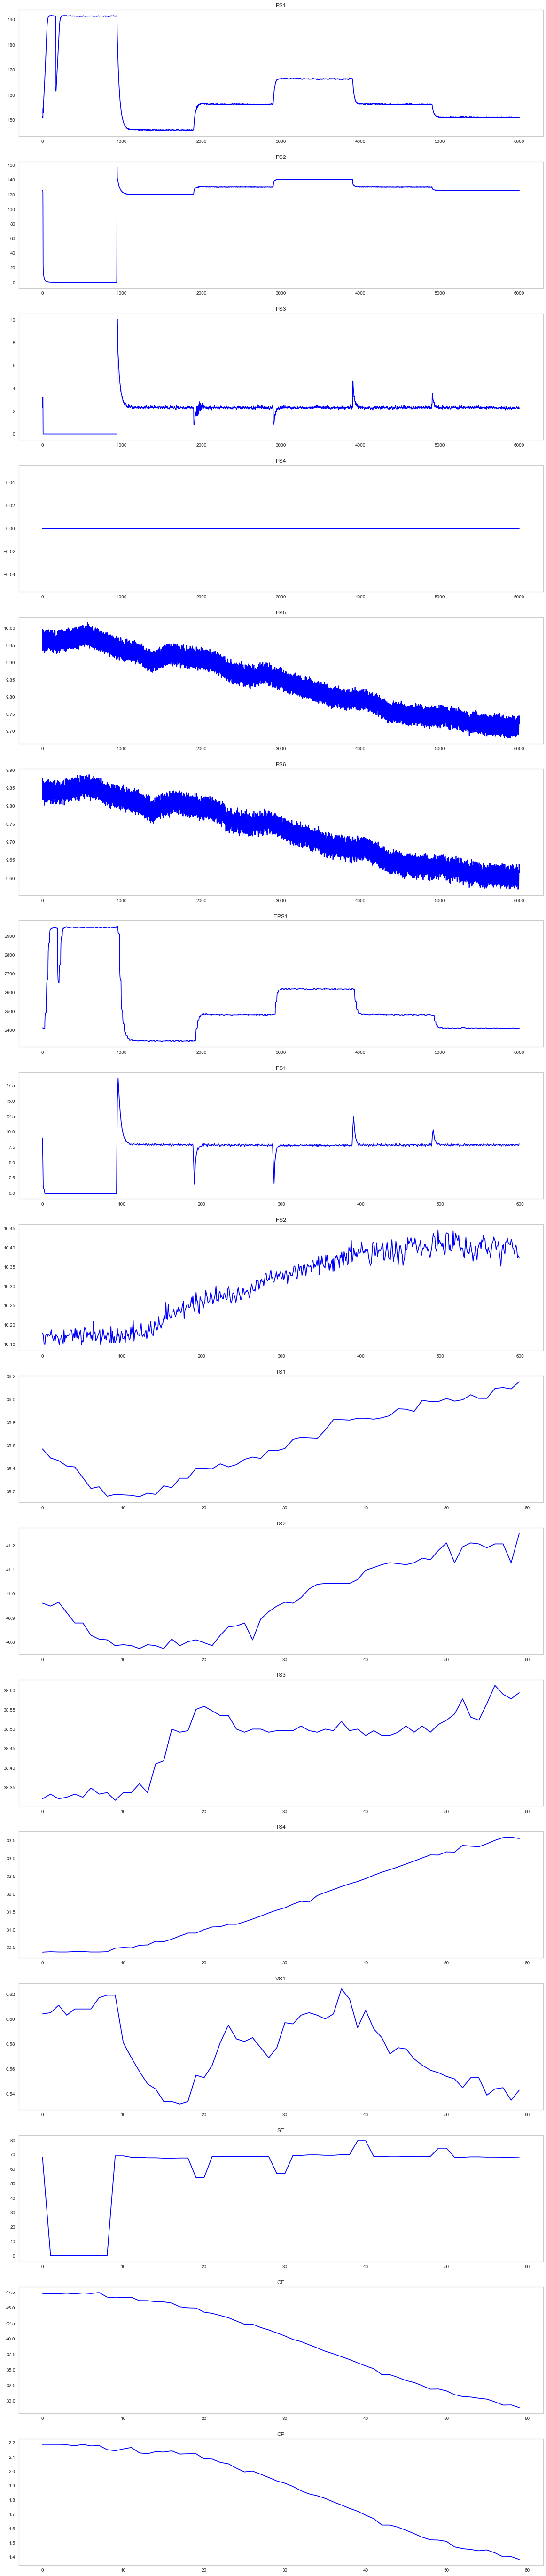

In [5]:
# Grafico de señales
fig, axs = plt.subplots(17,figsize=(20, 100))
for i,col in enumerate(df_x.dtype.names):
    signal= df_x[col][0,:]
    axs[i].plot(signal[~np.isnan(signal)],color='blue',label=None)
    axs[i].set_title(col)
    axs[i].grid()

**Breve explicación de las gráficas**

El ciclo de trabajo comienza en el instante 0 donde se aplica energía a la bomba MP1 (EPS1) para inyectar fluido por el circuito primario . Al estar la valvula V10 cerrada, se eleva la presión PS1 (previa a la válvula) sin elevar la presión PS2. Una vez alcanzada la presión de trabajo(en el instante 1000 aproximadamente), se abre la válvula V10 lo cual eleva la presión PS2 y disminuye PS1. A partir de este punto el fluido pasa por la máquina destino, intentando mantener el flujo (FS1) y la presión PS3 aproximadamente constante.  

Una vez que abre la válvula V10, el aceite comienza a calentarse (TS1 y TS2). En estas condiciones, el circuito secundario toma liquido del tanque y lo circula por un enfriador que desciende la temperatura de TS3 a TS4.

### Estadísticos

In [6]:
for col in df_x.dtype.names:
    print("----------------------------------------")
    print(col)
    print(f'nan: {np.sum(np.isnan(df_x[col]))}')
    print(f'unique: {len(np.unique(df_x[col]))}')
    print(f'min: {np.nanmin(df_x[col])}')
    print(f'max: {np.nanmax(df_x[col])}')
    print(f'mean: {np.nanmean(df_x[col])}')
    print(f'std: {np.nanstd(df_x[col])}')

----------------------------------------
PS1
nan: 0
unique: 4581
min: 133.1300048828125
max: 191.9199981689453
mean: 160.4853148787345
std: 16.13333028163704
----------------------------------------
PS2
nan: 0
unique: 12100
min: 0.0
max: 167.77000427246094
mean: 109.37990626819101
std: 48.10317157402828
----------------------------------------
PS3
nan: 0
unique: 1096
min: 0.0
max: 18.827999114990234
mean: 1.7532274926304299
std: 0.9347073805518215
----------------------------------------
PS4
nan: 0
unique: 8145
min: 0.0
max: 10.265999794006348
mean: 2.600265957945768
std: 4.297607137777727
----------------------------------------
PS5
nan: 0
unique: 1495
min: 8.317999839782715
max: 10.041000366210938
mean: 9.163320087504657
std: 0.5765989263674267
----------------------------------------
PS6
nan: 0
unique: 1433
min: 8.267999649047852
max: 9.90999984741211
mean: 9.079362751920243
std: 0.54992710636848
----------------------------------------
EPS1
nan: 0
unique: 4404
min: 2097.80004882812

Dada la gran cantidad de NaN, se debe estudiar el motivo por el cual están presentes.

## Salidas
* Nombres de las señales.
* Tipos de datos
* Estadísticos
* Distribuciones

### Nombres de señales y tipos de datos

In [7]:
df_y.dtype.fields

mappingproxy({'CoolerCondition': (dtype('int32'), 0),
              'ValveCondition': (dtype('int32'), 4),
              'Internal Pump Leakage': (dtype('int32'), 8),
              'HydraulicAcumulator': (dtype('int32'), 12),
              'StableFlag': (dtype('int32'), 16)})

El objetivo entonces es predecir la condición de 4 componentes:
* Condición del enfriador.
* Condición de la válvula principal (V10).
* Condición de pérdidas en la bomba principal.
* Condición de pérdidas en acumulador hidráulico de reserva.

**Nota: la columna Stable Flag hace referencia a si el sistema se encuentra en operación estable y no es de interés para este trabajo por lo que se descarta** 

In [8]:
df_y=df_y[np.array(df_y.dtype.names)[:-1]]

Las salidas parecen ser en principio del tipo numéricas. Se analiza con mayor detalle.

### Estadísticos

In [9]:
for col in df_y.dtype.names:
    print("----------------------------------------")
    print(col)
    print(f'nan: {np.sum(np.isnan(df_y[col]))}')
    print(f'unique: {len(np.unique(df_y[col]))}')
    print(f'unique values: {np.unique(df_y[col])}')

----------------------------------------
CoolerCondition
nan: 0
unique: 3
unique values: [  3  20 100]
----------------------------------------
ValveCondition
nan: 0
unique: 4
unique values: [ 73  80  90 100]
----------------------------------------
Internal Pump Leakage
nan: 0
unique: 3
unique values: [0 1 2]
----------------------------------------
HydraulicAcumulator
nan: 0
unique: 4
unique values: [ 90 100 115 130]


A pesar de ser valores numéricos, como solo hay 3 o 4 valores diferentes, es de sospechar que estos valores codifican categorías.

Estudiando el paper que da origen al dataset, se observa que efectivamente se trata de categorías:

1- Condición del enfriador: 
    
    100 -> eficiencia óptima
    
    20 -> eficiencia reducida
    
    3 -> riesgo de falla total
    
2- Condición de la válvula principal:
    
    100 -> óptima
    
    90 -> atascamiento leve
    
    80 -> atascamiento severo
    
    73 -> riesgo de falla total


3- Condición de pérdidas en la bomba principal:
    
    0 -> sin fugas
    
    1 -> fugas leves
    
    2 -> fugas severas


4- Condición de pérdidas en acumulador hidráulico de reserva:

    130 -> sin pérdidas
    
    115 -> pérdidas leves
    
    100 -> pérdidas severas
    
    90 -> riesgo de falla total

**El problema entonces se puede dividir como 4 problemas de clasificación multiclase**

In [10]:
# Mapeo valores numéricos a categorías
cooler_map = {100: 'eficiencia optima' , 20:'eficiencia reducida' ,  3:'riesgo de falla total'}
valve_map = { 100:'optima', 90:'atascamiento leve', 80: 'atascamiento severo' , 73 : 'riesgo de falla total'}
pump_map = {0:'sin fugas', 1:'fugas leves', 2:'fugas severas'}
acumulator_map = {130 :'sin perdidas', 115:'perdidas leves', 100:'perdidas severas', 90:'riesgo de falla total'}
outputs_maps= [cooler_map, valve_map, pump_map, acumulator_map]

In [11]:
df_y_cat = pd.DataFrame()
for i,col in enumerate(df_y.dtype.names):
    df_y_cat[col] = [outputs_maps[i][value] for value in df_y[col]]
df_y_cat

,CoolerCondition,ValveCondition,Internal Pump Leakage,HydraulicAcumulator
0,riesgo de falla total,optima,sin fugas,sin perdidas
1,riesgo de falla total,optima,sin fugas,sin perdidas
2,riesgo de falla total,optima,sin fugas,sin perdidas
3,riesgo de falla total,optima,sin fugas,sin perdidas
4,riesgo de falla total,optima,sin fugas,sin perdidas
...,...,...,...,...
2200,eficiencia optima,optima,sin fugas,riesgo de falla total
2201,eficiencia optima,optima,sin fugas,riesgo de falla total
2202,eficiencia optima,optima,sin fugas,riesgo de falla total
2203,eficiencia optima,optima,sin fugas,riesgo de falla total


### DIstribuciones

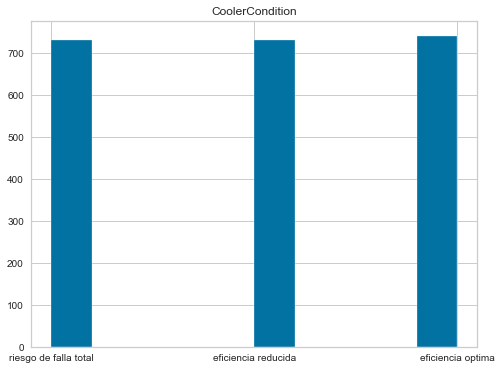

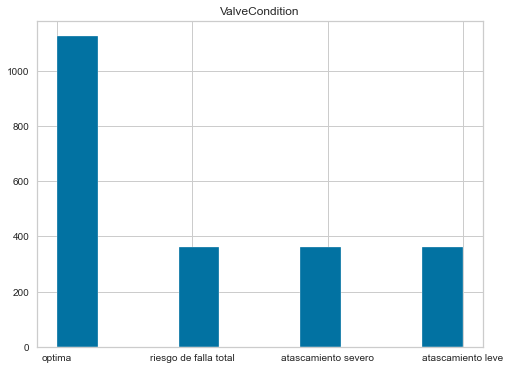

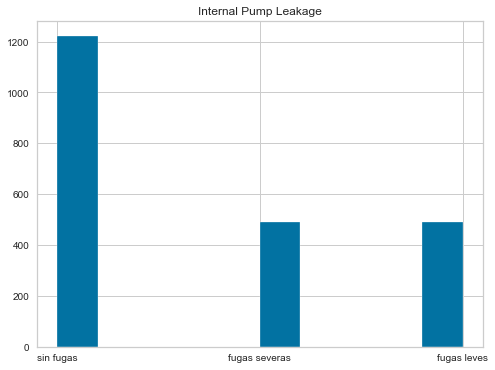

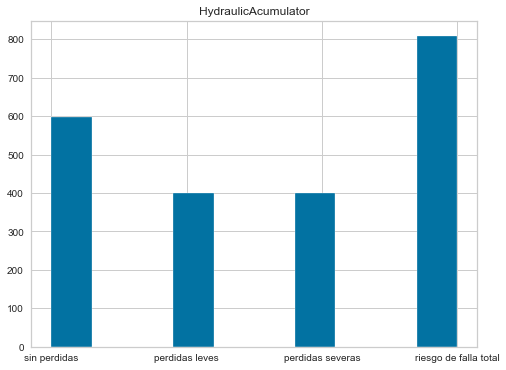

In [12]:
for col in df_y_cat.columns:
    output = df_y_cat[col]
    fig, ax = plt.subplots(1,figsize=(8,6))
    ax.hist(output)
    ax.set_title(col)

En el caso de condición de cooler y estado del acumulador las clases se encuentran balanceadas mientras que en el caso de condición de válvula y condición de bomba hay un claro desbalance de clases.

# Limpieza de datos

*   Analisis NaN
*   Tratamiento de NaN

## Analisis NaN

In [13]:
for col in df_x.dtype.names:
    print(f'{col} nan: {np.sum(np.isnan(df_x[col]))}')

PS1 nan: 0
PS2 nan: 0
PS3 nan: 0
PS4 nan: 0
PS5 nan: 0
PS6 nan: 0
EPS1 nan: 0
FS1 nan: 11907000
FS2 nan: 11907000
TS1 nan: 13097700
TS2 nan: 13097700
TS3 nan: 13097700
TS4 nan: 13097700
VS1 nan: 13097700
SE nan: 13097700
CE nan: 13097700
CP nan: 13097700


In [14]:
# Analizo los primeros valores de FS1 
df_x['FS1'][0,0:100]

array([8.98999977e+00,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan, 7.69999981e-01,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
       6.40999973e-01,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan, 6.00000005e-03,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
       0.00000000e+00,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan, 0.00000000e+00,            nan,
                  nan,            nan,            nan,            nan,
      

In [15]:
np.argwhere(~np.isnan(df_x['FS1'][0,:])).T

array([[   0,   10,   20,   30,   40,   50,   60,   70,   80,   90,  100,
         110,  120,  130,  140,  150,  160,  170,  180,  190,  200,  210,
         220,  230,  240,  250,  260,  270,  280,  290,  300,  310,  320,
         330,  340,  350,  360,  370,  380,  390,  400,  410,  420,  430,
         440,  450,  460,  470,  480,  490,  500,  510,  520,  530,  540,
         550,  560,  570,  580,  590,  600,  610,  620,  630,  640,  650,
         660,  670,  680,  690,  700,  710,  720,  730,  740,  750,  760,
         770,  780,  790,  800,  810,  820,  830,  840,  850,  860,  870,
         880,  890,  900,  910,  920,  930,  940,  950,  960,  970,  980,
         990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090,
        1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200,
        1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310,
        1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420,
        1430, 1440, 1450, 1460, 1470, 

Observamos que cada 10 muestras de PS1, hay una muestra de FS1.
Los NaN se corresponden entonces a momentos donde no se muestrea la señal por tener diferentes frecuencias de adquisición.

* FS1 y FS2 se adquieren a una frecuencia 10 veces menor a PS1

In [16]:
np.argwhere(~np.isnan(df_x['TS1'][0,:])).T

array([[   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
        1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
        2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200,
        3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300,
        4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400,
        5500, 5600, 5700, 5800, 5900]], dtype=int64)

* TS1 a TS4, VS1, SE, CE, y CP se adquieren a una frecuencia 100 veces menor a PS1.

## Tratamiento NaN

Para tratar los NaN podemos submuestrear todas las señales a la frecuencia mas baja, pero perderíamos muchos datos en el proceso. Se opta por computar los NaN utilizando interpolación.

In [17]:
# Computo NaN con valores interpolados
for col in df_x.dtype.names:
    aux = pd.DataFrame(df_x[col].transpose()) 
    aux = aux.interpolate()
    aux = np.array(aux).transpose()
    df_x[col] = aux

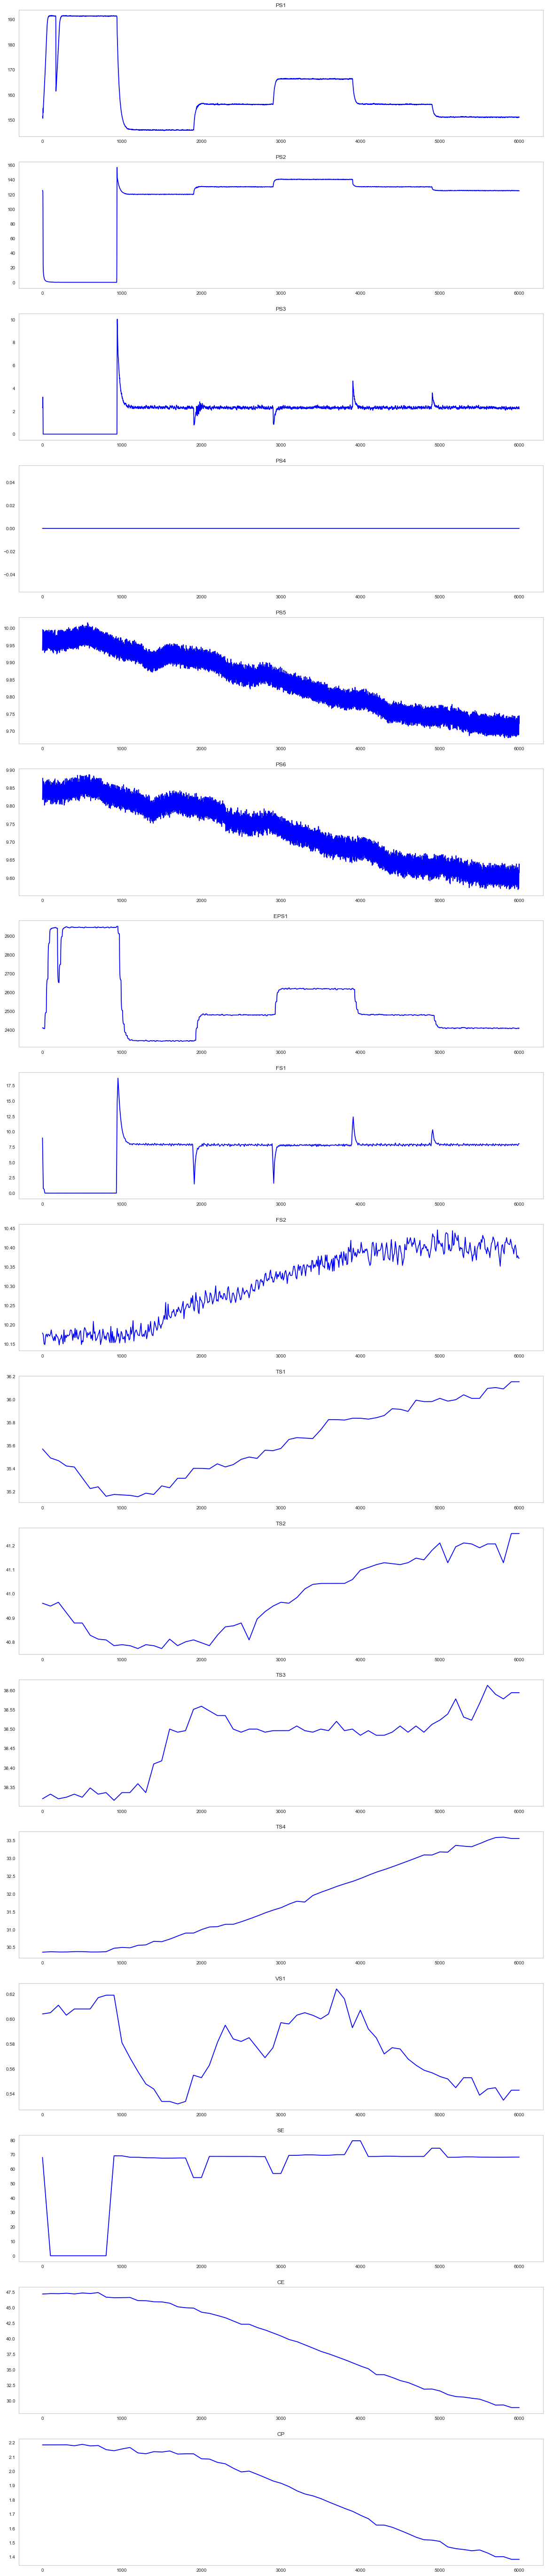

In [18]:
# Grafico nuevamente las señales
fig, axs = plt.subplots(17,figsize=(20, 100))
for i,col in enumerate(df_x.dtype.names):
    signal= df_x[col][0,:]
    axs[i].plot(signal[~np.isnan(signal)],color='blue',label=None)
    axs[i].set_title(col)
    axs[i].grid()

In [19]:
# Chequeo nuevas estadisticas
for col in df_x.dtype.names:
    print("----------------------------------------")
    print(col)
    print(f'nan: {np.sum(np.isnan(df_x[col]))}')
    print(f'unique: {len(np.unique(df_x[col]))}')
    print(f'min: {np.nanmin(df_x[col])}')
    print(f'max: {np.nanmax(df_x[col])}')
    print(f'mean: {np.nanmean(df_x[col])}')
    print(f'std: {np.nanstd(df_x[col])}')

----------------------------------------
PS1
nan: 0
unique: 4581
min: 133.1300048828125
max: 191.9199981689453
mean: 160.4853148787345
std: 16.13333028163704
----------------------------------------
PS2
nan: 0
unique: 12100
min: 0.0
max: 167.77000427246094
mean: 109.37990626819101
std: 48.10317157402828
----------------------------------------
PS3
nan: 0
unique: 1096
min: 0.0
max: 18.827999114990234
mean: 1.7532274926304299
std: 0.9347073805518215
----------------------------------------
PS4
nan: 0
unique: 8145
min: 0.0
max: 10.265999794006348
mean: 2.600265957945768
std: 4.297607137777727
----------------------------------------
PS5
nan: 0
unique: 1495
min: 8.317999839782715
max: 10.041000366210938
mean: 9.163320087504657
std: 0.5765989263674267
----------------------------------------
PS6
nan: 0
unique: 1433
min: 8.267999649047852
max: 9.90999984741211
mean: 9.079362751920243
std: 0.54992710636848
----------------------------------------
EPS1
nan: 0
unique: 4404
min: 2097.80004882812

**Se corrobora que la interpolación se aplicó correctamente y no se han modificado las distribuciones**

# Esquema de validación de resultados

Particionaremos el dataset en entrenamiento y testeo (80-20). 

Sobre la partición de entrenamiento aplicaremos KFolds con 5 grupos para realizar el ajuste fino de hiperparámetros de modelo y obtener las métricas de validación.

Una vez ajustado los modelos, haremos un cálculo final de performance sobre el dataset de testeo.

In [20]:
x_train, x_test, y_train, y_test = train_test_split( df_x, df_y_cat, test_size=0.2, shuffle=True, random_state =5)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1764, 6000)
(1764, 4)
(441, 6000)
(441, 4)


# Ingeniería de features

Trabajar directamente con las señales 'raw' sería problemático debido a varias cuestiones como: gran dimensionalidad (6000 muestras por 17 señales equivalen a 102000 features), gran varianza en los valores del mismo instante de tiempo (por ruido de campo y de medición, desvíos progresivos en los sensores), gran descorrelación en valores (features) del mismo instante de tiempo (por retrasos de tiempo comunes en series de tiempo). 

Por este motivo se decide realizar la siguiente transformación:
- Se divide cada señal en 5 segmentos. El valor 5 se seleccionó en forma aleatoria y sería un hiperparámetro en el caso de querer optener el modelo con mejores resultados.

- Sobre cada segmento se aplican estadísticos. En este caso tomaremos: media, desviación estándar, oblicuidad y kurtosis. La cantidad de estadísticos tomados también se puede pensar como un hiperparámetro.


Una vez hecha la transformación pasaremos de un dataset de 2205 muestras, 6000 puntos y 17 señales a un dataset de 2205 muestras con 340 features (17 señales x 5 segmentos x 4 estadísticos). 

Sobre este dataset transformado, se harán los siguientes análisis:

* Correlaciones.
* Relación con la salida.
* plot-box de las variables mas correlacionadas con la salida

## Transformación a dataset de características

In [21]:
# Dataset de características train
df_train_char = pd.DataFrame()

n_sectors = 5
step = int(x_train.shape[1]/n_sectors)

for col in x_train.dtype.names:
    for i in range(0,n_sectors):
        df_train_char[f'Mean {i} - {col}']=np.mean(x_train[col][:,(i*step):((i+1)*step)],axis=1)
        df_train_char[f'Std {i} - {col}']=np.std(x_train[col][:,(i*step):((i+1)*step)],axis=1)
        df_train_char[f'Kurtosis {i} - {col}']=stats.kurtosis(x_train[col][:,(i*step):((i+1)*step)],axis=1)
        df_train_char[f'Skew {i} - {col}']=stats.skew(x_train[col][:,(i*step):((i+1)*step)],axis=1)
        
df_train_char

<ipython-input-21-66be41dfc1b3>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train_char[f'Mean {i} - {col}']=np.mean(x_train[col][:,(i*step):((i+1)*step)],axis=1)
<ipython-input-21-66be41dfc1b3>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train_char[f'Std {i} - {col}']=np.std(x_train[col][:,(i*step):((i+1)*step)],axis=1)
<ipython-input-21-66be41dfc1b3>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = f

,Mean 0 - PS1,Std 0 - PS1,Kurtosis 0 - PS1,Skew 0 - PS1,Mean 1 - PS1,Std 1 - PS1,Kurtosis 1 - PS1,Skew 1 - PS1,Mean 2 - PS1,Std 2 - PS1,...,Kurtosis 2 - CP,Skew 2 - CP,Mean 3 - CP,Std 3 - CP,Kurtosis 3 - CP,Skew 3 - CP,Mean 4 - CP,Std 4 - CP,Kurtosis 4 - CP,Skew 4 - CP
0,181.296624,17.155404,-0.137159,-1.307464,149.986368,4.630860,-1.816018,0.403426,161.290192,4.875248,...,-1.117484,0.747019,2.172211,0.005020,-0.405212,-0.285842,2.170153,0.012382,0.450585,1.017730
1,178.781668,18.895443,-0.231456,-1.277994,158.717108,22.257091,-1.666335,0.532645,188.554083,0.093828,...,-1.538899,-0.502273,1.481535,0.009981,-1.706347,-0.052934,1.489625,0.002981,-0.697611,0.168253
2,182.248041,16.635284,0.352036,-1.485637,149.931409,4.579103,-1.831056,0.390743,161.169058,4.948383,...,-1.157911,0.685681,2.154375,0.002034,-0.812192,0.126396,2.149131,0.007378,-1.162596,-0.530932
3,180.054217,18.553872,-0.268104,-1.267123,147.377892,4.841877,-1.828656,0.391832,158.986917,4.926481,...,-0.107209,-0.542210,1.695380,0.010254,-0.875375,0.110161,1.684709,0.005132,0.913865,-1.028260
4,180.501983,18.098900,-0.223164,-1.280241,148.134725,4.816382,-1.822361,0.397591,159.794142,4.973179,...,0.084498,1.060039,1.742477,0.015017,-1.270332,-0.215979,1.723154,0.009824,1.163086,1.394720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759,179.495284,18.860751,-0.284617,-1.259038,146.143058,4.760254,-1.827929,0.392312,157.569151,4.815589,...,0.131779,1.041064,1.936182,0.017331,0.235795,-0.757084,1.928990,0.014111,-0.940100,-0.598654
1760,181.325908,17.347189,0.245754,-1.435828,147.824350,4.768500,-1.814598,0.397892,159.384350,4.908218,...,-1.370453,-0.442529,1.735587,0.003456,-0.528115,-0.295639,1.733703,0.003487,-0.233431,0.377082
1761,182.483392,16.575451,0.375197,-1.492916,150.203209,4.648868,-1.830127,0.391702,161.456983,4.846007,...,-0.829079,-0.914264,2.150550,0.009371,-0.868011,-0.747924,2.139829,0.006252,-0.619999,0.434787
1762,181.766624,17.197520,0.319997,-1.473494,148.220551,4.808852,-1.825798,0.393250,159.776675,4.951839,...,0.154313,0.754290,1.723623,0.011203,-1.506196,0.371775,1.722332,0.008735,-1.331690,0.654869


In [22]:
# Dataset de características test
df_test_char = pd.DataFrame()

n_sectors = 5
step = int(x_test.shape[1]/n_sectors)

for col in x_test.dtype.names:
    for i in range(0,n_sectors):
        df_test_char[f'Mean {i} - {col}']=np.mean(x_test[col][:,(i*step):((i+1)*step)],axis=1)
        df_test_char[f'Std {i} - {col}']=np.std(x_test[col][:,(i*step):((i+1)*step)],axis=1)
        df_test_char[f'Kurtosis {i} - {col}']=stats.kurtosis(x_test[col][:,(i*step):((i+1)*step)],axis=1)
        df_test_char[f'Skew {i} - {col}']=stats.skew(x_test[col][:,(i*step):((i+1)*step)],axis=1)
        
df_test_char

<ipython-input-22-61702b93a7f3>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test_char[f'Mean {i} - {col}']=np.mean(x_test[col][:,(i*step):((i+1)*step)],axis=1)
<ipython-input-22-61702b93a7f3>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test_char[f'Std {i} - {col}']=np.std(x_test[col][:,(i*step):((i+1)*step)],axis=1)
<ipython-input-22-61702b93a7f3>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame

,Mean 0 - PS1,Std 0 - PS1,Kurtosis 0 - PS1,Skew 0 - PS1,Mean 1 - PS1,Std 1 - PS1,Kurtosis 1 - PS1,Skew 1 - PS1,Mean 2 - PS1,Std 2 - PS1,...,Kurtosis 2 - CP,Skew 2 - CP,Mean 3 - CP,Std 3 - CP,Kurtosis 3 - CP,Skew 3 - CP,Mean 4 - CP,Std 4 - CP,Kurtosis 4 - CP,Skew 4 - CP
0,181.441250,17.100707,-0.113826,-1.316341,150.111067,4.642437,-1.815742,0.403578,161.463024,4.821674,...,-0.998030,0.885142,2.156847,0.005495,2.498399,1.520048,2.155495,0.003876,0.364749,0.710347
1,181.528842,17.543332,-0.189701,-1.299993,150.513467,4.887176,-1.827687,0.393336,162.028068,4.808933,...,-0.123124,-0.671342,2.159174,0.010084,-1.276013,-0.391189,2.141167,0.003823,-0.512454,-0.619558
2,181.535384,17.525261,-0.194967,-1.298027,150.526050,4.859069,-1.828900,0.392304,162.019334,4.827454,...,0.496076,1.133765,2.141301,0.005637,0.881748,0.032810,2.144204,0.010348,0.201505,0.210884
3,178.755524,18.853192,-0.385863,-1.211278,145.751342,4.577784,-1.829307,0.389578,156.889484,4.760180,...,-1.351583,0.066934,1.492602,0.019720,-0.628803,-0.367772,1.454788,0.005380,-1.065924,-0.570130
4,181.220025,17.361574,-0.202963,-1.286147,150.077217,4.665985,-1.817594,0.402048,161.382125,4.781513,...,-1.608224,-0.357000,2.142133,0.007886,-0.771638,-0.178989,2.136499,0.005066,4.042249,1.884947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,181.067283,17.421967,-0.235873,-1.273349,150.042542,4.697637,-1.813951,0.404563,161.364650,4.792374,...,-0.251573,-0.625752,2.135873,0.003928,-0.024144,0.824489,2.140288,0.003863,-0.906086,0.090338
437,178.358302,19.073824,-0.336072,-1.232579,158.236767,22.200198,-1.633133,0.556033,188.470832,0.099126,...,-0.271801,0.981113,1.511270,0.016212,-0.942453,-0.418788,1.525008,0.012727,-1.194402,0.365673
438,179.422333,18.813381,-0.088031,-1.323085,145.957259,5.038772,-1.832841,0.368223,157.224975,4.822261,...,0.312251,1.010687,1.566288,0.012476,-1.670964,0.287815,1.588040,0.007694,-0.586372,0.650849
439,181.171283,17.510547,-0.178128,-1.303100,149.956260,4.656307,-1.828043,0.393362,161.174759,4.825122,...,1.108266,0.841207,2.164758,0.008616,-1.222072,0.629245,2.154620,0.008751,0.153821,-0.427362


## Correlaciones

In [23]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

corr = df_train_char.corr().abs().unstack()
labels_to_drop = get_redundant_pairs(df_train_char)
corr = corr.drop(labels=labels_to_drop).sort_values(ascending=False)

In [24]:
corr[corr>0.9]

Mean 4 - PS5       Mean 4 - PS6    0.999992
Mean 2 - PS5       Mean 2 - PS6    0.999992
Mean 3 - PS5       Mean 3 - PS6    0.999992
Mean 0 - PS5       Mean 0 - PS6    0.999992
Mean 1 - PS5       Mean 1 - PS6    0.999992
                                     ...   
Kurtosis 2 - EPS1  Std 1 - FS1     0.900237
Mean 0 - PS1       Mean 2 - FS2    0.900157
Mean 0 - TS2       Mean 3 - CP     0.900135
Mean 0 - TS1       Std 0 - TS1     0.900035
Std 0 - TS1        Mean 4 - TS3    0.900013
Length: 2616, dtype: float64

In [25]:
corr[(corr>0.6) &  (corr<0.9)]

Mean 4 - TS1      Mean 4 - CP         0.899818
Mean 2 - TS2      Mean 0 - CP         0.899805
Std 3 - PS2       Kurtosis 1 - FS1    0.899741
Kurtosis 2 - PS3  Std 4 - PS3         0.899709
Skew 1 - PS1      Std 4 - TS2         0.899612
                                        ...   
Kurtosis 4 - FS1  Std 3 - SE          0.600224
Std 3 - PS5       Mean 3 - PS6        0.600176
Skew 1 - FS1      Std 2 - FS2         0.600147
Kurtosis 1 - PS1  Kurtosis 1 - SE     0.600136
Std 3 - PS5       Mean 4 - TS4        0.600072
Length: 4628, dtype: float64

In [26]:
corr[(corr<0.6)]

Kurtosis 1 - PS3   Std 1 - VS1        0.599991
Mean 1 - PS5       Skew 1 - SE        0.599989
Std 0 - PS2        Std 1 - TS2        0.599971
Kurtosis 1 - PS5   Std 0 - TS1        0.599964
Mean 4 - PS3       Skew 1 - PS5       0.599902
                                        ...   
Kurtosis 3 - EPS1  Std 2 - CP         0.000024
Std 4 - VS1        Skew 3 - CP        0.000017
Mean 4 - SE        Kurtosis 4 - CP    0.000015
Kurtosis 4 - EPS1  Skew 4 - TS3       0.000008
Kurtosis 0 - PS4   Std 2 - PS4        0.000005
Length: 50386, dtype: float64

Observamos que dada la naturaleza de las features existe gran correlación entre muchas de ellas. En especial entre diferentes estadísticos calculados sobre el mismo segmento de la misma señal (ejemplo media 1 y kurtosis 1 PS2) y entre el mismo estadístico calculado en el mismo segmento entre diferentes señales correlacionadas (ejemplo PS5 y PS6).

También se observan algunas correlaciones a priori no intuitivas como Mean 0 PS1 y Mean 2 FS2 que son estadísticos de dos magnitudes físicas distintas, de momentos de tiempo diferentes y de circuitos diferentes (primario y secundario). Casos como estos requerirían un análisis experto del banco de prueba.

La conclusión que se obtiene de las correlaciones es que resultaría de gran beneficio hacer una selección de variables previo al entrenamiento de modelos. Esto disminuiría el costo computacional, reduciría la información redundante y mejoraría la inmunidad del modelo a ruido, ausencia de variables, entre otras cosas.

## Relación con las salidas

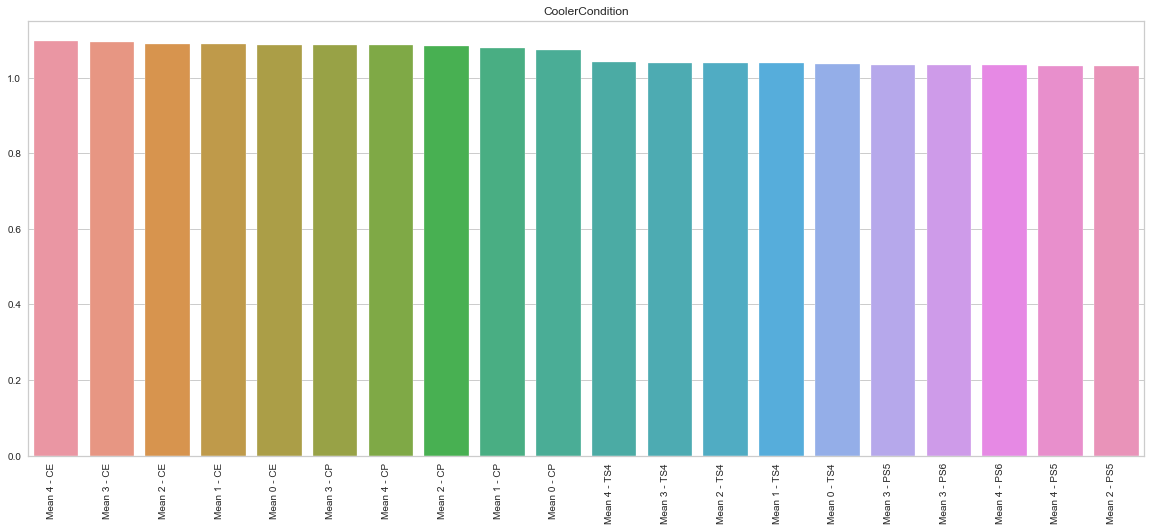

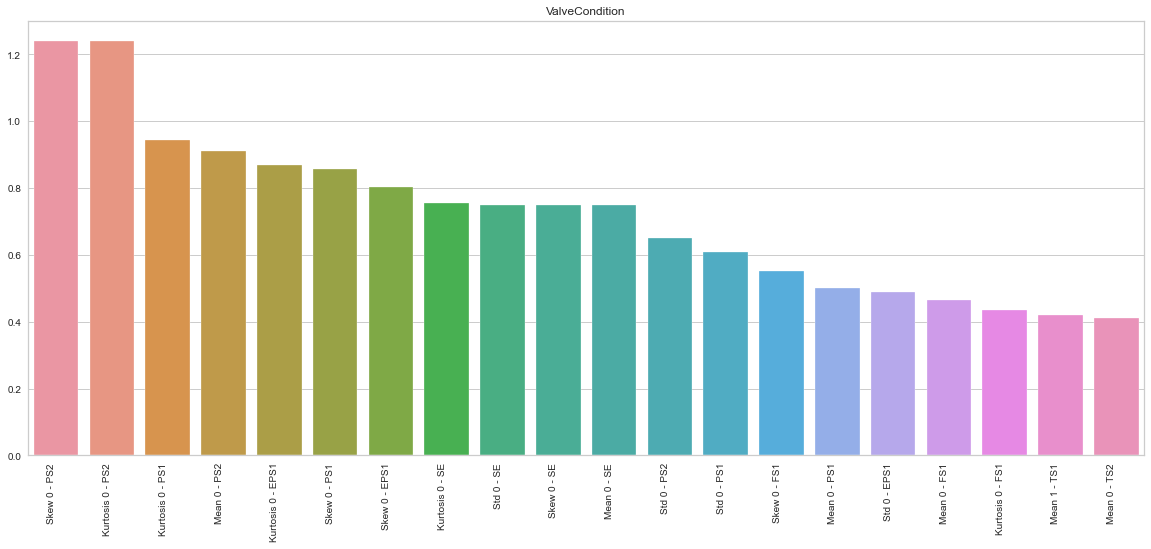

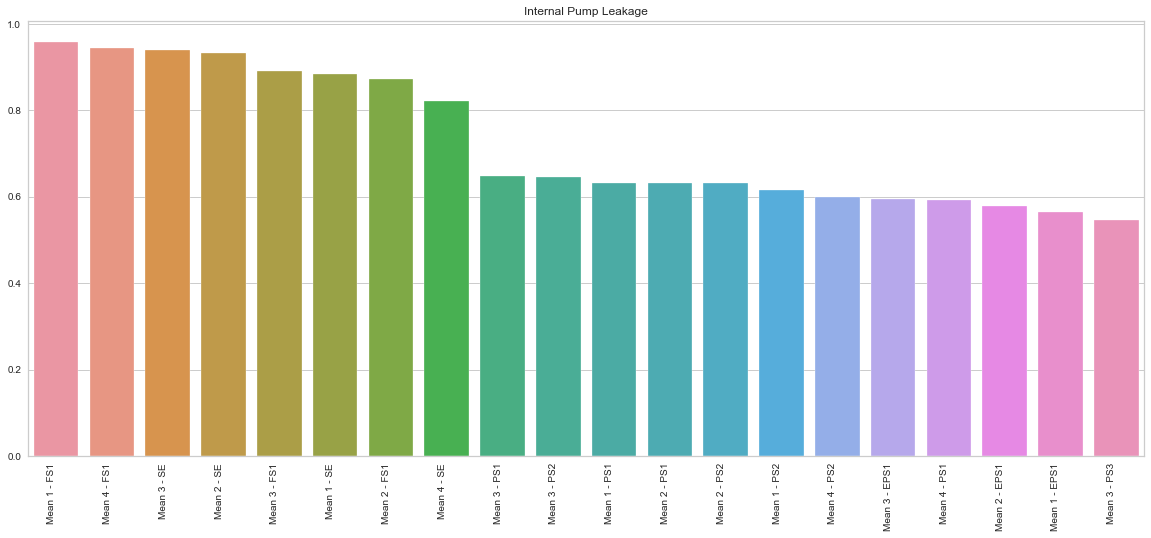

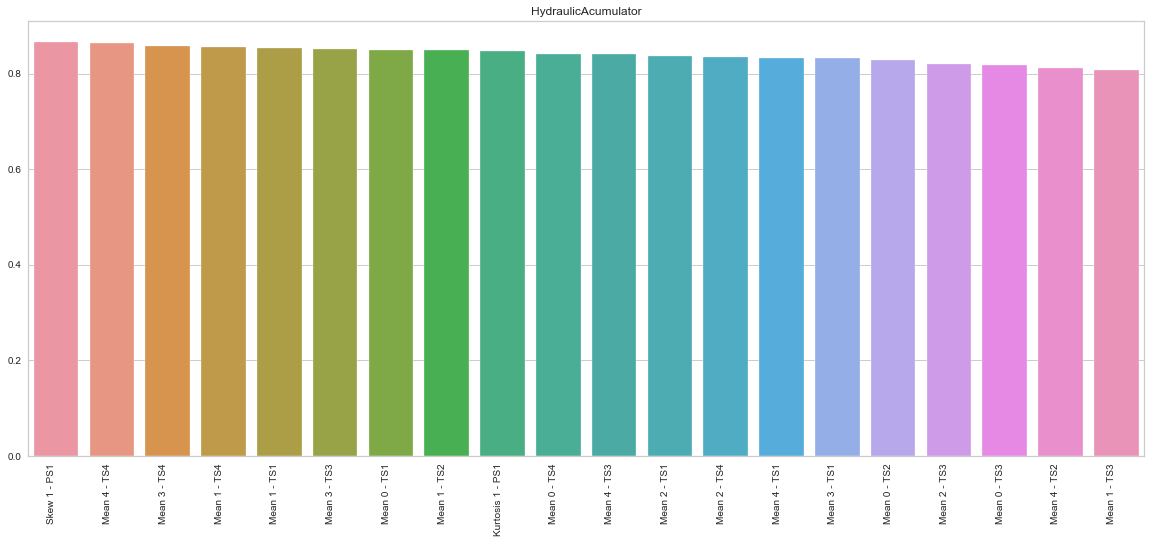

In [27]:
mutual_info_top_signals=[]

def select_features_mutual_info(X_train, y_train,k= 'all'):  
    fs = SelectKBest(score_func=mutual_info_classif, k=k )  
    fs.fit(X_train, y_train)  
    return fs

for ycol in y_train.columns:
    fs = select_features_mutual_info(df_train_char, y_train[ycol],20)
    kfeatures= np.argsort(fs.scores_)[-1:-21:-1]
    fig,axes = plt.subplots(1,1,figsize=(20,8))
    bar = sns.barplot( x = df_train_char.columns[kfeatures] , y = fs.scores_[kfeatures],ax=axes)
    bar.set_xticklabels(bar.get_xticklabels(), rotation=90, horizontalalignment='right')
    bar.set_title(ycol)
    plt.show()
    mutual_info_top_signals.append(df_train_char.columns[kfeatures])

Aplicando información mutua, se obtiene:

- Para la condición del cooler, resultan importantes la media de CE (señal "virtual") que aproxima la eficiencia del enfriamiento, la media de la potencia del enfriador y la media de la temperatura TS4. Analizando el sistema parece ser correcto.

- Para la condición de la válvula, son importantes la kurtosis y oblicuidad en el primer segmento de PS2. Esto tiene sentido,  ya que la válvula en cuestión es la que abre el circuito para que se levante presión en PS2 en el instante 1000 aproximadamente.

- Para las perdidas en la bomba principal, se marca como importante la media de FS1 que es el caudal de aceite por el circuito principal.

- Para el nivel en el acumulador de reserva, se marca como importante la oblicuidad de PS1 y las medias de las distintas temperaturas. Este correlación es dificil de interpretar contra el análisis del sistema.

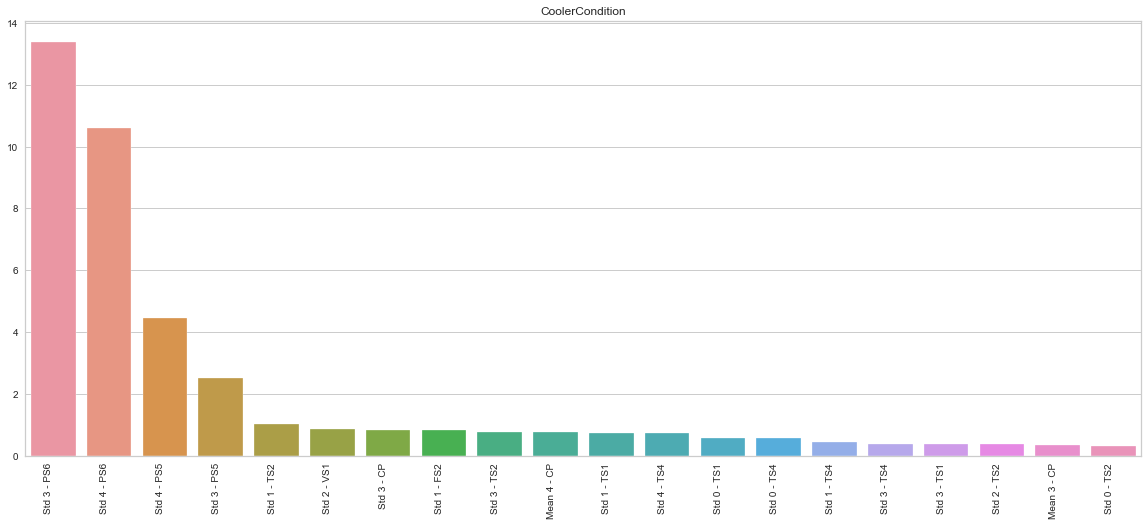

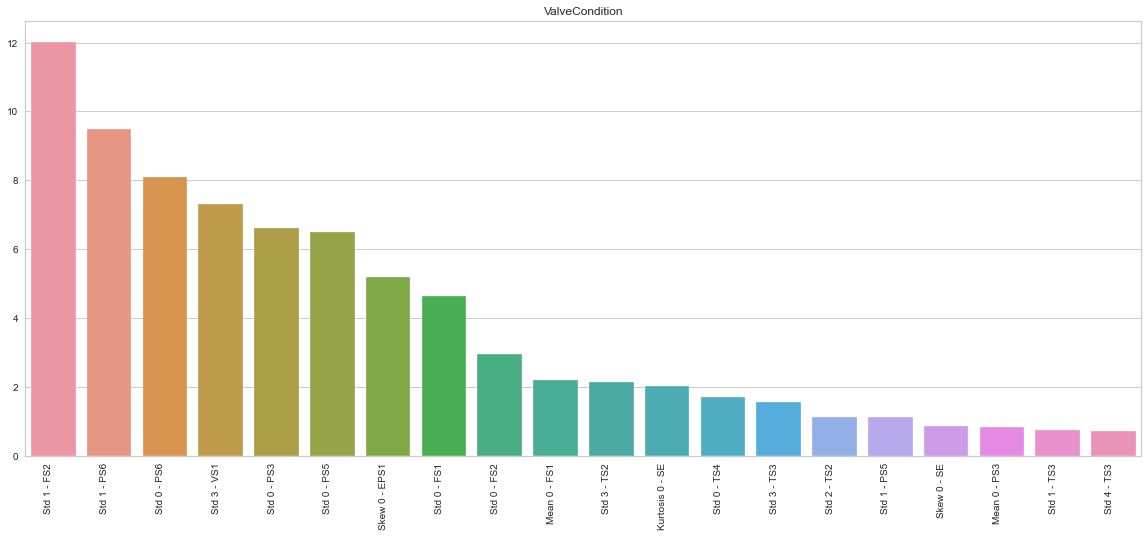

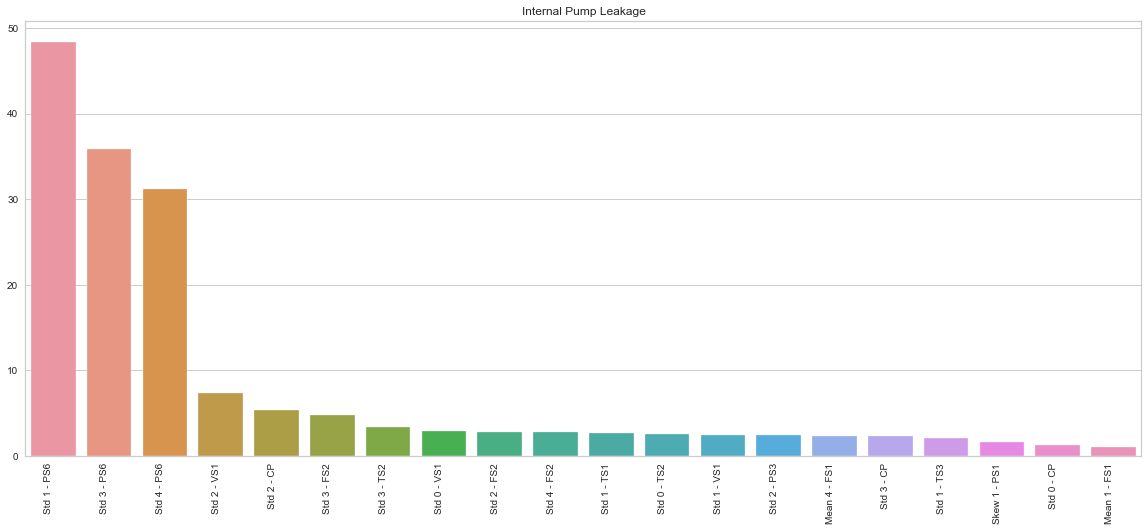

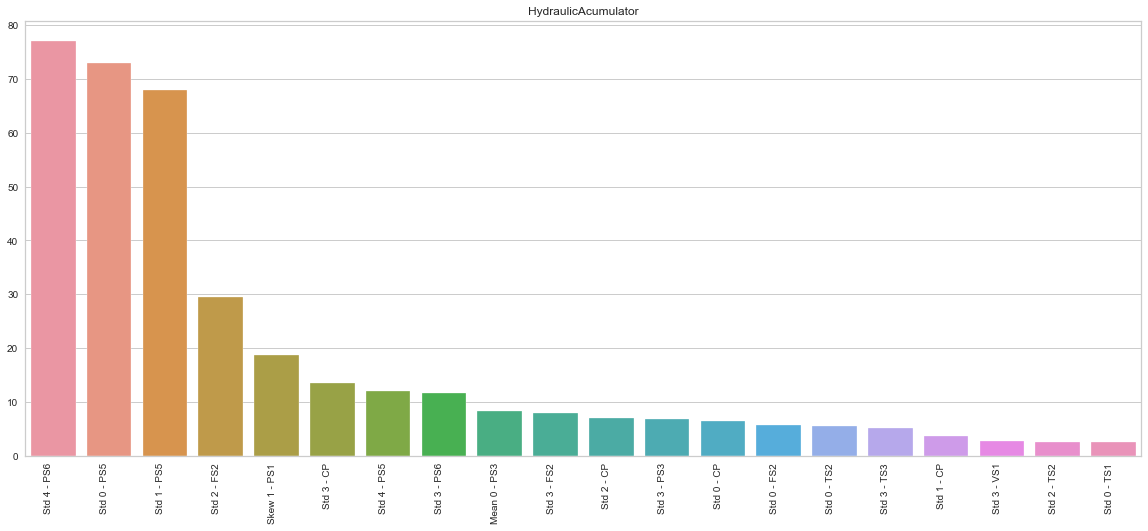

In [28]:
# Ahora utilizamos lasso para comprobar las relaciones con otro método
from sklearn.preprocessing import LabelEncoder

lasso_top_signals=[]

for ycol in y_train.columns:
    lassoreg = Lasso(alpha=0.0001,normalize=True, max_iter=10000)
    lassoreg.fit(df_train_char, LabelEncoder().fit_transform(y_train[ycol]))
    kfeatures= np.argsort(np.abs(lassoreg.coef_))[-1:-21:-1]
    fig,axes = plt.subplots(1,1,figsize=(20,8))
    bar = sns.barplot( x = df_train_char.columns[kfeatures] , y = np.abs(lassoreg.coef_[kfeatures]),ax=axes)
    bar.set_xticklabels(bar.get_xticklabels(), rotation=90, horizontalalignment='right')
    bar.set_title(ycol)
    plt.show()
    lasso_top_signals.append(df_train_char.columns[kfeatures])

Aplicando Lasso, se obtiene:

- Para la condición del cooler, resultan importantes la desviación estandar en PS5 y PS6. Se puede llegar a intuir esta correlación teniendo en cuenta que PS5 y PS6 miden la presión antes y después del cooler.

- Para la condición de la válvula, es importante la desviación en FS2 y la desviación estándar en PS5. Esta relación no es visible en el circuito, más aún pertenecen al cirucito secundario y la válvula al primario.

- Para las perdidas en la bomba principal, se marca como importante el desvío estándar en PS6. Estas correlaciones no son visibles en el circuito físico.

- Para el nivel en el acumulador de reserva, se marca como importante la desviación estandar en PS5 y PS6. Estas correlaciones no son visibles en el circuito físico.

**A partir de lo observado, y a fin de reducir dimensiones, se decide tomar para cada salida las 10 variables de entrada más importantes marcadas por cada método**

In [29]:
top_signals=[]
for i in range(len(mutual_info_top_signals)):
    top_signals.append( np.unique(\
                                  [mutual_info_top_signals[i][0:10], \
                                   lasso_top_signals[i][0:10]]))

In [30]:
top_signals

[array(['Mean 0 - CE', 'Mean 0 - CP', 'Mean 1 - CE', 'Mean 1 - CP',
        'Mean 2 - CE', 'Mean 2 - CP', 'Mean 3 - CE', 'Mean 3 - CP',
        'Mean 4 - CE', 'Mean 4 - CP', 'Std 1 - FS2', 'Std 1 - TS2',
        'Std 2 - VS1', 'Std 3 - CP', 'Std 3 - PS5', 'Std 3 - PS6',
        'Std 3 - TS2', 'Std 4 - PS5', 'Std 4 - PS6'], dtype=object),
 array(['Kurtosis 0 - EPS1', 'Kurtosis 0 - PS1', 'Kurtosis 0 - PS2',
        'Kurtosis 0 - SE', 'Mean 0 - FS1', 'Mean 0 - PS2', 'Skew 0 - EPS1',
        'Skew 0 - PS1', 'Skew 0 - PS2', 'Skew 0 - SE', 'Std 0 - FS1',
        'Std 0 - FS2', 'Std 0 - PS3', 'Std 0 - PS5', 'Std 0 - PS6',
        'Std 0 - SE', 'Std 1 - FS2', 'Std 1 - PS6', 'Std 3 - VS1'],
       dtype=object),
 array(['Mean 1 - FS1', 'Mean 1 - SE', 'Mean 2 - FS1', 'Mean 2 - SE',
        'Mean 3 - FS1', 'Mean 3 - PS1', 'Mean 3 - PS2', 'Mean 3 - SE',
        'Mean 4 - FS1', 'Mean 4 - SE', 'Std 0 - VS1', 'Std 1 - PS6',
        'Std 2 - CP', 'Std 2 - FS2', 'Std 2 - VS1', 'Std 3 - FS2',
        'S

# Entrenamiento de modelos

Al tratarse de clasificaciones multiclase, se entrenaran modelos de regresión logística, random forest y redes neuronales. Compararemos los modelos entre si y contra un modelo base. Como métrica de comparación utilizaremos el AUC y emplearemos KFolds como mecanismo de validación.

Por ser multiclase, el AUC se computa promediando el AUC de cada clase contra el resto de las clases.

In [31]:
results = {}

In [32]:
def EvaluateKFolds(in_model, X, y, k=5):
    train_auc=0
    valid_auc=0
    
    kf = KFold(n_splits=k)
    kf.get_n_splits(X)
    
    y = np.array(y)
    enc = OneHotEncoder(handle_unknown='ignore') 
    y_encoded = enc.fit_transform(y.reshape(-1,1)).toarray()
    
    for train_index, valid_index in kf.split(X, y):
        
        x_valid = X.iloc[valid_index]
        y_valid = y[valid_index]
        y_enc_valid = y_encoded[valid_index]
        x_train = X.iloc[train_index]
        y_train = y[train_index]
        y_enc_train = y_encoded[train_index]
        
        scaler = preprocessing.MinMaxScaler()
        
        x_train_norm = scaler.fit_transform(x_train)
        x_valid_norm = scaler.transform(x_valid)
        
        model.fit(x_train_norm, y_train)
        pred_train = model.predict_proba(x_train_norm)
        pred_valid = model.predict_proba(x_valid_norm)
        
        train_auc = train_auc + roc_auc_score(y_enc_train, pred_train,multi_class='ovr') / k
        valid_auc = valid_auc + roc_auc_score(y_enc_valid, pred_valid,multi_class='ovr') / k

    return train_auc, valid_auc

In [33]:
total_results={}
for ycol in y_train.columns:
    total_results[ycol]={}

## Modelo base

In [34]:
class RandomModel(object):

    def fit(self, X, y):
        self.yshape=len(np.unique(y))
        return None

    def predict_proba(self, X):
        return np.random.uniform(0,1, size=(X.shape[0],self.yshape))

In [35]:
results={}
for i,ycol in enumerate(y_train.columns):

    model = RandomModel()
    train_auc, valid_auc = EvaluateKFolds(model, df_train_char[top_signals[i]], y_train[ycol], 5)
    
    total_results[ycol]['Base']= {}
    total_results[ycol]['Base']["Train KFolds AUC"] = train_auc
    total_results[ycol]['Base']["Valid KFolds AUC"] = valid_auc
    
    results[ycol]={}
    results[ycol]["Train KFolds AUC"] = train_auc
    results[ycol]["Valid KFolds AUC"] = valid_auc
    
pd.DataFrame(results).T

,Train KFolds AUC,Valid KFolds AUC
CoolerCondition,0.503094,0.497926
ValveCondition,0.498086,0.502520
Internal Pump Leakage,0.498474,0.500906
HydraulicAcumulator,0.495042,0.517494


**Como era de esperarse, al ser totalmente aleatorio, el modelo base tiene un AUC de 0.5**

## RandomForest

In [36]:
results={}
for i,ycol in enumerate(y_train.columns):

    model = RandomForestClassifier(n_estimators=200, random_state=5)
    train_auc, valid_auc = EvaluateKFolds(model, df_train_char[top_signals[i]],y_train[ycol], 5)

    total_results[ycol]['Randdom Forest']= {}
    total_results[ycol]['Randdom Forest']["Train KFolds AUC"] = train_auc
    total_results[ycol]['Randdom Forest']["Valid KFolds AUC"] = valid_auc
    
    results[ycol]={}
    results[ycol]["Train KFolds AUC"] = train_auc
    results[ycol]["Valid KFolds AUC"] = valid_auc
    
pd.DataFrame(results).T

,Train KFolds AUC,Valid KFolds AUC
CoolerCondition,1.0,1.000000
ValveCondition,1.0,1.000000
Internal Pump Leakage,1.0,0.999988
HydraulicAcumulator,1.0,0.997640


El Random Forest obtuvo resultados prácticamente excelentes. Era de esperarse, ya que aproxima bien relaciones no lineales y tiene muy buena performance con datos tabulares, pero aún así excedió las espectativas. En base a esto podemos concluir que la elección de división en 5 secciones y la elección de los estadísticos fue acertada, así también la reducción de dimensiones.

## Logistic Reression

In [37]:
results={}
for i,ycol in enumerate(y_train.columns):

    model = LogisticRegression(max_iter=1000,random_state=5)
    train_auc, valid_auc = EvaluateKFolds(model, df_train_char[top_signals[i]],y_train[ycol], 5)

    total_results[ycol]['Logistic Regression']= {}
    total_results[ycol]['Logistic Regression']["Train KFolds AUC"] = train_auc
    total_results[ycol]['Logistic Regression']["Valid KFolds AUC"] = valid_auc
    
    results[ycol]={}
    results[ycol]["Train KFolds AUC"] = train_auc
    results[ycol]["Valid KFolds AUC"] = valid_auc
    
pd.DataFrame(results).T

,Train KFolds AUC,Valid KFolds AUC
CoolerCondition,0.999719,0.999716
ValveCondition,0.998868,0.998200
Internal Pump Leakage,0.942959,0.935464
HydraulicAcumulator,0.806070,0.797480


Regresión logísitca también obtuvo muy buenos resultados, lo que refuerza la idea de que la selección de divisiones y estadísiticos fue acertada.

También notamos que en el caso del acumulador hay un decenso marcado de perfromance. En este caso las relaciones no lineales deben aportar información muy valiosa, razón por la cual el random forest obtiene mejores resultados.

## Redes neuronales

Utilizaremos como redes neuronales, redes convolucionales con una arquitectura simple basada en LeNet-5.

Las redes seran entrenadas con las señales "raw". 

**El beneficio es que en este caso no debemos seleccionar el número de divisiones o los estadísticos a calcular, sino que la red neuronal aprende los mejores "filtros" por si misma.**

In [38]:
class DeepModel(object):

    def fit(self, X, y):
        
        inputs = Input(shape=(6000,17,1))
        x = Conv2D(filters=64,kernel_size=(100,1), padding="valid", activation="relu")(inputs)
        x = MaxPool2D(pool_size=(10,1),strides=(10,1))(x)
        x = Conv2D(filters=128,kernel_size=(100,1), padding="valid", activation="relu")(x)
        x = MaxPool2D(pool_size=(10,1),strides=(10,1))(x)
        x = Conv2D(filters=256,kernel_size=(10,17), padding="valid", activation="relu")(x)
        x = MaxPool2D(pool_size=(10,1),strides=(10,1))(x)
        x = Flatten()(x)
        x = Dense(units=100,activation="relu")(x)
        x = Dense(units=100,activation="relu")(x)
        x = Dense(units=y.shape[1], activation="softmax")(x)
        self.model = Model(inputs, x)
        
        self.model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=AUC())
        self.model.summary()

        history=self.model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

        return history
    
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)

In [39]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [40]:
results={}
for i,ycol in enumerate(y_train.columns):

    model = DeepModel()

    enc = OneHotEncoder(handle_unknown='ignore') 
    y_encoded = enc.fit_transform( np.array(y_train[ycol]).reshape(-1,1)).toarray()

    history=model.fit(x_train.view(np.float64).reshape(x_train.shape + (-1,1)), y_encoded)

    total_results[ycol]['DeepModel']= {}
    total_results[ycol]['DeepModel']["Train KFolds AUC"] = history.history[list(history.history)[1]][-1]
    total_results[ycol]['DeepModel']["Valid KFolds AUC"] = history.history[list(history.history)[3]][-1]
    
    results[ycol]={}
    results[ycol]["Train KFolds AUC"] = history.history[list(history.history)[1]][-1]
    results[ycol]["Valid KFolds AUC"] = history.history[list(history.history)[3]][-1]


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6000, 17, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 5901, 17, 64)      6464      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 590, 17, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 491, 17, 128)      819328    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 17, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 1, 256)        5570816   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 1, 256)        

Epoch 1/10
45/45 [==============================] - 17s 387ms/step - loss: 6.1865 - auc_2: 0.5797 - val_loss: 1.2315 - val_auc_2: 0.7154
Epoch 2/10
45/45 [==============================] - 17s 373ms/step - loss: 1.2606 - auc_2: 0.6476 - val_loss: 0.9468 - val_auc_2: 0.7510
Epoch 3/10
45/45 [==============================] - 17s 386ms/step - loss: 0.9789 - auc_2: 0.7181 - val_loss: 0.9942 - val_auc_2: 0.7229
Epoch 4/10
45/45 [==============================] - 18s 389ms/step - loss: 1.0462 - auc_2: 0.6956 - val_loss: 0.8454 - val_auc_2: 0.8166
Epoch 5/10
45/45 [==============================] - 18s 390ms/step - loss: 0.8718 - auc_2: 0.7832 - val_loss: 0.9163 - val_auc_2: 0.7905
Epoch 6/10
45/45 [==============================] - 18s 390ms/step - loss: 0.9233 - auc_2: 0.7592 - val_loss: 0.7774 - val_auc_2: 0.8443
Epoch 7/10
45/45 [==============================] - 18s 390ms/step - loss: 0.8791 - auc_2: 0.7802 - val_loss: 1.0885 - val_auc_2: 0.6978
Epoch 8/10
45/45 [=======================

In [41]:
pd.DataFrame(results).T

,Train KFolds AUC,Valid KFolds AUC
CoolerCondition,0.988634,0.997173
ValveCondition,1.000000,1.000000
Internal Pump Leakage,0.788410,0.825049
HydraulicAcumulator,0.786717,0.802532


## Hiperparameter Tunning

Dados los excelentes resultados obtenidos, no se ve necesario hacer un ajuste fino de hiperparámetros (quedará pendiente para una próxima ampliación del trabajo, en la asignatura de AMQ2).

# Resultados

In [42]:
for ycol in y_train.columns:
    print("---------------------------------------------------------")
    print(ycol)
    print("")
    print(pd.DataFrame(total_results[ycol]).T)
    print("")

---------------------------------------------------------
CoolerCondition

                     Train KFolds AUC  Valid KFolds AUC
Base                         0.503094          0.497926
Randdom Forest               1.000000          1.000000
Logistic Regression          0.999719          0.999716
DeepModel                    0.988634          0.997173

---------------------------------------------------------
ValveCondition

                     Train KFolds AUC  Valid KFolds AUC
Base                         0.498086           0.50252
Randdom Forest               1.000000           1.00000
Logistic Regression          0.998868           0.99820
DeepModel                    1.000000           1.00000

---------------------------------------------------------
Internal Pump Leakage

                     Train KFolds AUC  Valid KFolds AUC
Base                         0.498474          0.500906
Randdom Forest               1.000000          0.999988
Logistic Regression          0.942959   

Los mejores resultados los obtuvo Random Forest lo cual es razonable por su potencia y capacidad de captar relaciones no lineales. También es de destacar los buenos resultados de la regresión logísitca lo que indica que la ingeniería de features aplicada fue correcta. El modelo de redes neuronales obtuvo resultados correctos (excepto para el acumulador hidráulico) y tiene el beneficio que no es necesario calcular buenos estadísticos sino que los obtiene en forma automática aplicando filtros, pero como contrapartida se debe diseñar una buena arquitectura para tener buenos resultados (mas notorio en el último caso) y requiere un poder de cómputo mucho mayor.

Finalmente, a modo de verificación final, obtendremos las métricas del Random Forest (modelo ganador) sobre el set de test.

In [43]:
def TestModel(in_model, x_train, y_train, x_test, y_test):
    train_auc=0
    test_auc=0
    
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    enc = OneHotEncoder(handle_unknown='ignore') 
    y_enc_train = enc.fit_transform(y_train.reshape(-1,1)).toarray()
    y_enc_test = enc.transform(y_test.reshape(-1,1)).toarray()
        
    scaler = preprocessing.MinMaxScaler()
        
    x_train_norm = scaler.fit_transform(x_train)
    x_test_norm = scaler.transform(x_test)
        
    model.fit(x_train_norm, y_train)
    pred_train = model.predict_proba(x_train_norm)
    pred_test = model.predict_proba(x_test_norm)
        
    train_auc = roc_auc_score(y_enc_train, pred_train,multi_class='ovr')
    test_auc = roc_auc_score(y_enc_test, pred_test,multi_class='ovr')

    return train_auc, test_auc

In [44]:
test_results={}
for i,ycol in enumerate(y_train.columns):

    model = RandomForestClassifier(n_estimators=200, random_state=5)
    train_auc, test_auc = TestModel(model, df_train_char[top_signals[i]],y_train[ycol],\
                                            df_test_char[top_signals[i]],y_test[ycol])

    
    test_results[ycol]={}
    test_results[ycol]["Train AUC"] = train_auc
    test_results[ycol]["Test AUC"] = test_auc
    
pd.DataFrame(test_results).T

,Train AUC,Test AUC
CoolerCondition,1.0,1.000000
ValveCondition,1.0,1.000000
Internal Pump Leakage,1.0,1.000000
HydraulicAcumulator,1.0,0.998921


**Se comprueba la excelente performance**

# Extra

## K-Means

Se aplicará K-Means para agrupar en forma no supervisada los puntos del caso de condición de válvula y comprobaremos con las etiquetas reales.

Del estudio del sistema, es sabido que para la condición de la válvula, las variables de mayor importancia son 'Skew 0 - PS2' y 'Kurtosis 0 - PS1'. Aplicaremos K-Means con estas 2 variables y se mostrarán las gráficas.

In [45]:
df_kmeans = df_train_char[['Skew 0 - PS2', 'Kurtosis 0 - PS1']]

In [46]:
# MinMaxScaler
scaler = preprocessing.MinMaxScaler()
df_kmeans_scaled = scaler.fit_transform(df_kmeans)

C:\Users\MaxiT\.conda\envs\GPU\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


Text(0, 0.5, 'SSE')

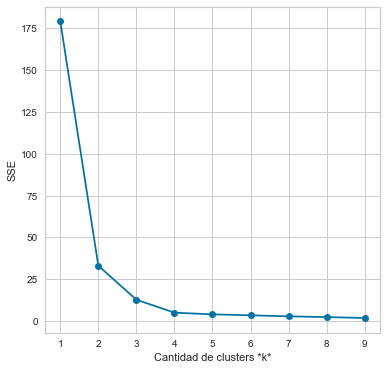

In [47]:
# Ejecuto el algoritmo con K entre 2 y 10 y guardo el error para luego graficarlo.
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(df_kmeans_scaled)
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters *k*')
plt.grid(True)
plt.ylabel('SSE')

In [48]:
list_k = list(range(2, 10))

for n_clusters in list_k:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(df_kmeans_scaled)
    centers = clusterer.cluster_centers_

    score = silhouette_score (df_kmeans_scaled, preds)
    print ("For n_clusters =" + str(n_clusters) + " silhouette score is " + str(score))

For n_clusters =2 silhouette score is 0.7483992481272613
For n_clusters =3 silhouette score is 0.7627148237202742
For n_clusters =4 silhouette score is 0.7731906542705321
For n_clusters =5 silhouette score is 0.7765433908302993
For n_clusters =6 silhouette score is 0.7345173746672276
For n_clusters =7 silhouette score is 0.7453702557086576
For n_clusters =8 silhouette score is 0.5752754225346639
For n_clusters =9 silhouette score is 0.5331700024048804


Observamos que claramente las mejores métricas se obtienen con K=4, lo cual concuerda con la cantidad de clases de la condición de válvula en el dataset. Graficamos los clúster obtenidos, comparando con las etiquetas reales.

In [49]:
km = KMeans(
    n_clusters=4, init='random',
    n_init=10, random_state=0
)

y_km = km.fit_predict(df_kmeans_scaled)

In [50]:
y_real =  LabelEncoder().fit_transform(y_train['ValveCondition'])

real_to_kmeans_classes_map = {0:statistics.mode(y_km[y_real==0]), \
                              1:statistics.mode(y_km[y_real==1]), \
                              2:statistics.mode(y_km[y_real==2]), \
                              3:statistics.mode(y_km[y_real==3])}

y_real = np.array([real_to_kmeans_classes_map[i] for i in y_real])

y_km_correct = (y_km == y_real)
y_km_incorrect = (y_km != y_real)

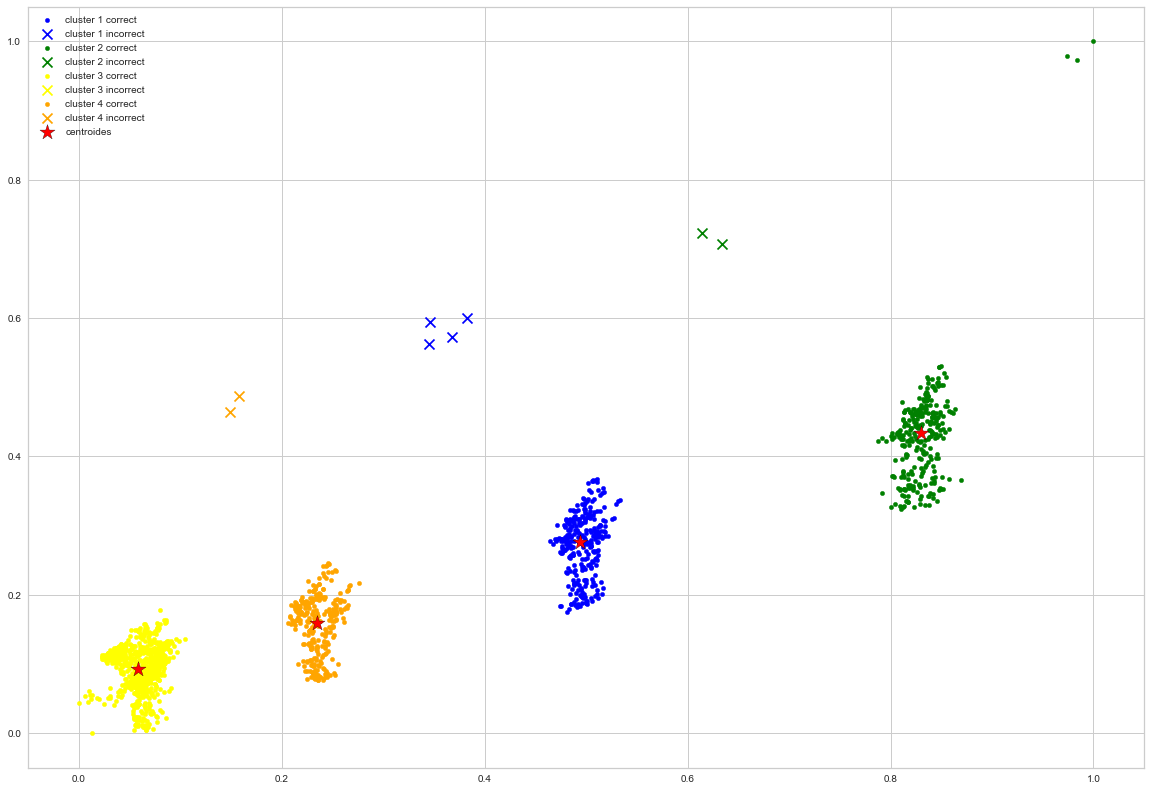

In [51]:
plt.figure(figsize=(20,14))

colors=['blue','green', 'yellow', 'orange']

for i,classes in enumerate(np.unique(y_km)):
    
    plt.scatter(
        df_kmeans_scaled[(y_km == classes) & (y_km_correct), 0], df_kmeans_scaled[(y_km == classes) & (y_km_correct), 1],
        s=20, c=colors[i],
        label=f'cluster {i+1} correct'
    )
    
    plt.scatter(
        df_kmeans_scaled[(y_km == classes) & (y_km_incorrect), 0], df_kmeans_scaled[(y_km == classes) & (y_km_incorrect), 1],
        s=100, c=colors[i], marker='x',
        label=f'cluster {i+1} incorrect'
    )
    
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroides'
)


plt.legend(scatterpoints=1)
#hace una grilla en el grafico
plt.grid(True)
#lo imprime en pantalla
plt.show()

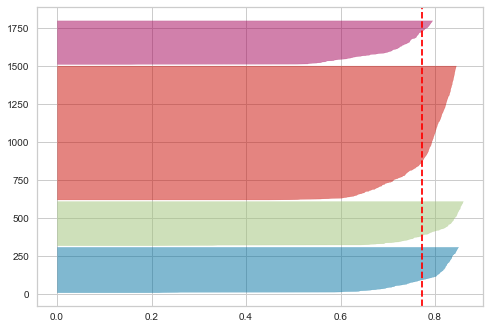

In [53]:
# Ploteo el gráfico de silueta
visualizer = SilhouetteVisualizer(km, colors='yellowbrick')    # Instancio el visualizador
visualizer.fit(df_kmeans_scaled)                                          # Entreno el visualizador con datos
plt.grid(True)

**Observamos que la elección de features fue muy buena para este problema y Kmeans descubre y agrupa prácticamente en forma perfecta los 4 grupos**